C:\Users\Strix\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


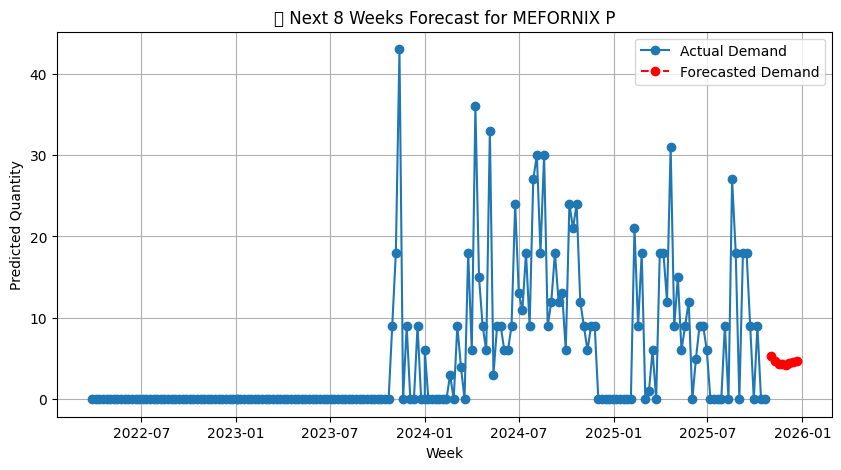


✅ Forecast complete for 'MEFORNIX P'!
💾 Saved as 'forecast_MEFORNIX_P_8weeks_XGB.xlsx'
     Medicine Future_Week_Label  Predicted_Quantity
0  MEFORNIX P     Future Week 1                   5
1  MEFORNIX P     Future Week 2                   5
2  MEFORNIX P     Future Week 3                   4
3  MEFORNIX P     Future Week 4                   4
4  MEFORNIX P     Future Week 5                   4
5  MEFORNIX P     Future Week 6                   4
6  MEFORNIX P     Future Week 7                   5
7  MEFORNIX P     Future Week 8                   5


In [1]:
# ==============================================
# 📦 Predict Next 8 Weeks (≈2 Months) with Saved XGBoost Model
# ==============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor

# ------------------- 1️⃣ Load Data -------------------
file_path = "../data/demand_prediction_weekly.xlsx"
#file_path = "C:\\Users\\Strix\\Desktop\\Boehm Tech\\demand forecasting\\demand_prediction_weekly.xlsx"
df = pd.read_excel(file_path)

# 🧍 Ask user to enter medicine name
medicine_name = input("Enter the medicine name: ").strip()

if medicine_name not in df['Product_Name'].unique():
    print(f"❌ Medicine '{medicine_name}' not found in dataset!")
    print("Available medicines:\n", df['Product_Name'].unique())
    exit()

df_med = df[df['Product_Name'] == medicine_name].copy()
df_med = df_med.sort_values('Week').reset_index(drop=True)

# ✅ Convert 'Week' strings like '2025-W43' → actual datetime (Monday of that week)
df_med['Week'] = pd.to_datetime(df_med['Week'] + '-1', format='%Y-W%W-%w')

# ------------------- 2️⃣ Feature Engineering -------------------
df_med['Month'] = np.ceil(df_med['Week_Number'] / 4.33).astype(int).clip(upper=12)
df_med['Quarter'] = ((df_med['Month'] - 1) // 3 + 1).astype(int)
df_med['Is_Year_Start'] = (df_med['Week_Number'] <= 4).astype(int)
df_med['Is_Year_End'] = (df_med['Week_Number'] >= 48).astype(int)
df_med['Sin_Week'] = np.sin(2 * np.pi * df_med['Week_Number'] / 52)
df_med['Cos_Week'] = np.cos(2 * np.pi * df_med['Week_Number'] / 52)

for lag in range(1, 13):
    df_med[f'lag_{lag}'] = df_med['Total_Quantity'].shift(lag)

df_med['rolling_mean_3'] = df_med['Total_Quantity'].shift(1).rolling(window=3).mean()
df_med['rolling_mean_5'] = df_med['Total_Quantity'].shift(1).rolling(window=5).mean()
df_med['rolling_mean_6'] = df_med['Total_Quantity'].shift(1).rolling(6).mean()
df_med['rolling_std_6'] = df_med['Total_Quantity'].shift(1).rolling(6).std()
df_med['rolling_mean_8'] = df_med['Total_Quantity'].shift(1).rolling(window=8).mean()
df_med['rolling_std_4'] = df_med['Total_Quantity'].shift(1).rolling(window=4).std()

df_med = df_med.dropna().reset_index(drop=True)

# ------------------- 3️⃣ Load Saved Model -------------------
model = XGBRegressor()
model.load_model("../saved models/xgboost_MEFORNIX P.json")

# ------------------- 4️⃣ Predict Future -------------------
future_weeks = 8  # next 8 weeks ≈ 2 months
last_known_week = df_med['Week_Number'].iloc[-1]
last_row = df_med.iloc[-1].copy()

predictions = []
future_week_labels = []

for i in range(1, future_weeks + 1):
    next_week_num = ((last_known_week + i - 1) % 52) + 1
    temp = last_row.copy()

    temp['Week_Number'] = next_week_num
    temp['Month'] = int(min(np.ceil(next_week_num / 4.33), 12))
    temp['Quarter'] = ((temp['Month'] - 1) // 3 + 1)
    temp['Is_Year_Start'] = int(next_week_num <= 4)
    temp['Is_Year_End'] = int(next_week_num >= 48)
    temp['Sin_Week'] = np.sin(2 * np.pi * next_week_num / 52)
    temp['Cos_Week'] = np.cos(2 * np.pi * next_week_num / 52)

    X_features = [c for c in df_med.columns if c not in ['Total_Quantity', 'Week', 'Product_Name']]
    X_input = temp[X_features].values.reshape(1, -1)

    y_pred = model.predict(X_input)[0]
    predictions.append(y_pred)
    future_week_labels.append(f"Future Week {i}")

    # Update lag features for next iteration
    for lag in range(12, 1, -1):
        temp[f'lag_{lag}'] = temp[f'lag_{lag-1}']
    temp['lag_1'] = y_pred

    last_row = temp.copy()

# ------------------- 5️⃣ Plot -------------------
# ✅ Generate future weekly dates for plotting
future_dates = pd.date_range(df_med['Week'].iloc[-1], periods=future_weeks + 1, freq='W')[1:]

plt.figure(figsize=(10, 5))
plt.plot(df_med['Week'], df_med['Total_Quantity'], label='Actual Demand', marker='o')
plt.plot(future_dates, predictions, label='Forecasted Demand', marker='o', linestyle='--', color='red')
plt.title(f"📈 Next 8 Weeks Forecast for {medicine_name}")
plt.xlabel("Week")
plt.ylabel("Predicted Quantity")
plt.legend()
plt.grid(True)
plt.show()

# ------------------- 6️⃣ Save Forecast -------------------
future_df = pd.DataFrame({
    "Medicine": medicine_name,
    "Future_Week_Label": future_week_labels,
    "Predicted_Quantity": [int(round(p)) for p in predictions] 
})
future_df.to_excel(f"../outputs/forecast_{medicine_name.replace(' ', '_')}_8weeks_XGB.xlsx", index=False)

print(f"\n✅ Forecast complete for '{medicine_name}'!")
print(f"💾 Saved as 'forecast_{medicine_name.replace(' ', '_')}_8weeks_XGB.xlsx'")
print(future_df)
